In [2]:
import pandas as pd
with open("manipal_atmospherics_df.csv", "r") as f:
    for i in range(10):
        print(f.readline())

latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation

13.321617,74.79452,97.0,19800,Asia/Kolkata,GMT+5:30



time,temperature_2m_mean (Â°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/mÂ²),apparent_temperature_mean (Â°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (Â°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (Â°C),soil_moisture_0_to_7cm_mean (mÂ³/mÂ³)

2011-01-04,24.7,0.00,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278

2011-01-05,25.4,0.00,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276

2011-01-06,26.2,0.00,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273

2011-01-07,25.6,0.00,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270

2011-01-08,25.2,0.00,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268

2011-01-09,25.2,0.00,20.82,28.4,18.3,4.49,37701.15,297,1008.0,52,20.0,0.266



In [3]:
df = pd.read_csv("manipal_atmospherics_df.csv",
    skiprows=3
)

In [5]:
df["time"] = pd.to_datetime(df["time"])
df['time'].dtype

dtype('<M8[ns]')

In [6]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
    .str.replace("°", "")
    .str.replace("²", "2")
    .str.replace("/", "_")
    .str.replace("³", "3")
)
df.columns

Index(['time', 'temperature_2m_mean_c', 'precipitation_sum_mm',
       'shortwave_radiation_sum_mj_m2', 'apparent_temperature_mean_c',
       'wind_speed_10m_max_km_h', 'et0_fao_evapotranspiration_mm',
       'sunshine_duration_s', 'wind_direction_10m_dominant_',
       'pressure_msl_mean_hpa', 'cloud_cover_mean_%', 'dew_point_2m_mean_c',
       'soil_moisture_0_to_7cm_mean_m3_m3'],
      dtype='object')

In [11]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def train_sequence_model(
    df,
    input_features,        # list of columns as inputs
    target_features,       # list of columns as targets
    model_type,     # "LSTM", "GRU", "RNN"
    window=14,
    hidden=64,
    epochs=20,
    num_layers = 2,
    lr=0.001,
    bidirectional = False,
    dropout = 0.0
):
    train_df = df[df["time"] < "2024-01-04"]
    val_df   = df[(df["time"] >= "2024-01-04") & (df["time"] < "2025-01-04")]
    test_df  = df[(df["time"] >= "2025-01-04") & (df["time"] <= "2026-01-04")]

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    train_x = x_scaler.fit_transform(train_df[input_features])
    val_x   = x_scaler.transform(val_df[input_features])
    test_x  = x_scaler.transform(test_df[input_features])
    
    train_y = y_scaler.fit_transform(train_df[target_features])
    val_y   = y_scaler.transform(val_df[target_features])
    test_y  = y_scaler.transform(test_df[target_features])

    def make_sequences(x, y, window):
        Xs = np.array([x[i:i+window] for i in range(len(x)-window)])
        ys = np.array([y[i+window] for i in range(len(x)-window)])
        # np.array is used because error was shown
        return torch.tensor(Xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

    X_train, y_train = make_sequences(train_x, train_y, window)
    X_val, y_val     = make_sequences(val_x, val_y, window)
    X_test, y_test   = make_sequences(test_x, test_y, window)

    input_size = X_train.shape[2]
    output_size = y_train.shape[1]

    class SequenceModel(nn.Module):
        def __init__(self, model_type, input_size, hidden, num_layers, output_size, bidirectional, dropout):
            super().__init__()
            if model_type == "LSTM":
                self.rnn = nn.LSTM(input_size, hidden, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
            elif model_type == "GRU":
                self.rnn = nn.GRU(input_size, hidden, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
            elif model_type == "RNN":
                self.rnn = nn.RNN(input_size, hidden, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
            else:
                raise ValueError("model_type must be 'LSTM', 'GRU', or 'RNN'")
            direction_factor = 2 if bidirectional else 1
            self.fc = nn.Linear(hidden * direction_factor, output_size)
        
        def forward(self, x):
            out, _ = self.rnn(x)
            return self.fc(out[:, -1, :])

    model = SequenceModel(model_type, input_size, hidden, num_layers, output_size, bidirectional, dropout)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
            val_losses.append(val_loss.item())

        if epoch % 5 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss.item():.4f}")


    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.title(f"{', '.join(target_features)} - {model_type} Train vs Val Loss")
    plt.legend()
    plt.show()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
    test_pred_np = y_scaler.inverse_transform(test_pred.numpy())
    test_true_np = y_scaler.inverse_transform(y_test.numpy())

    plt.figure(figsize=(14,5))
    for i, target in enumerate(target_features):
        plt.plot(test_df["time"].iloc[window:], test_true_np[:,i], label=f"{target} Actual")
        plt.plot(test_df["time"].iloc[window:], test_pred_np[:,i], label=f"{target} Predicted")
    plt.title(f"{', '.join(target_features)} Prediction (2025–2026) - {model_type}")
    plt.legend()
    plt.show()

    rmse = np.sqrt(mean_squared_error(test_true_np, test_pred_np))
    mae  = mean_absolute_error(test_true_np, test_pred_np)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    return model, test_true_np, test_pred_np


Device: cuda


Epoch 0 | Train: 0.9124 | Val: 1.0319
Epoch 5 | Train: 0.3105 | Val: 0.3198
Epoch 10 | Train: 0.2046 | Val: 0.2941
Epoch 15 | Train: 0.1650 | Val: 0.1833
Epoch 20 | Train: 0.1642 | Val: 0.1691
Epoch 25 | Train: 0.1415 | Val: 0.1785
Epoch 29 | Train: 0.1355 | Val: 0.1589


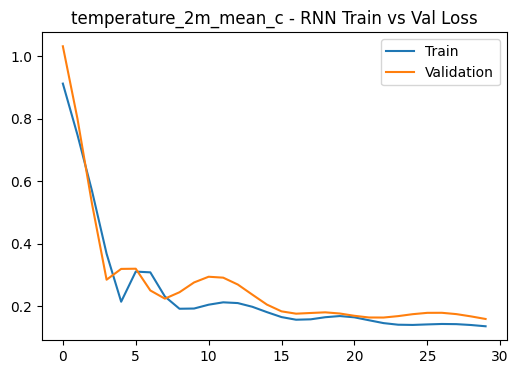

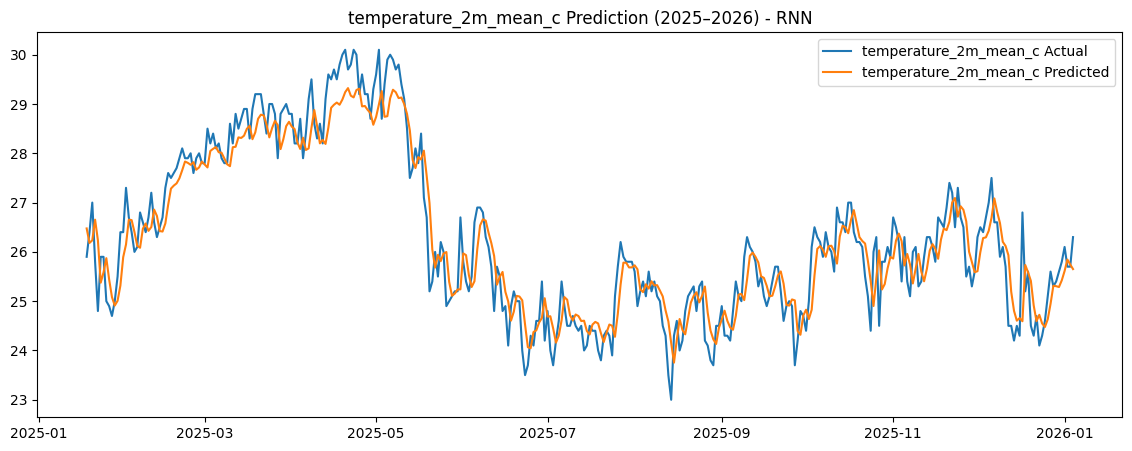

RMSE: 0.5656, MAE: 0.4492




Epoch 0 | Train: 1.0452 | Val: 1.3614
Epoch 5 | Train: 0.5746 | Val: 0.6262
Epoch 10 | Train: 0.2375 | Val: 0.3127
Epoch 15 | Train: 0.2083 | Val: 0.2082
Epoch 20 | Train: 0.2276 | Val: 0.2666
Epoch 25 | Train: 0.1928 | Val: 0.1964
Epoch 29 | Train: 0.1834 | Val: 0.1857


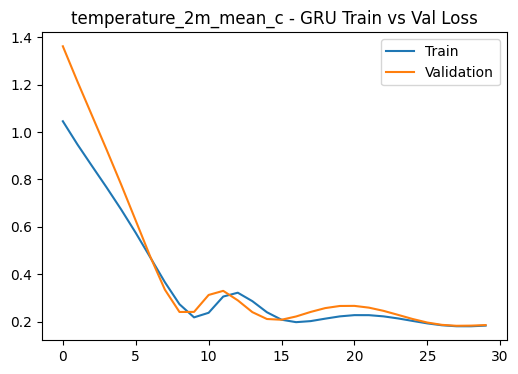

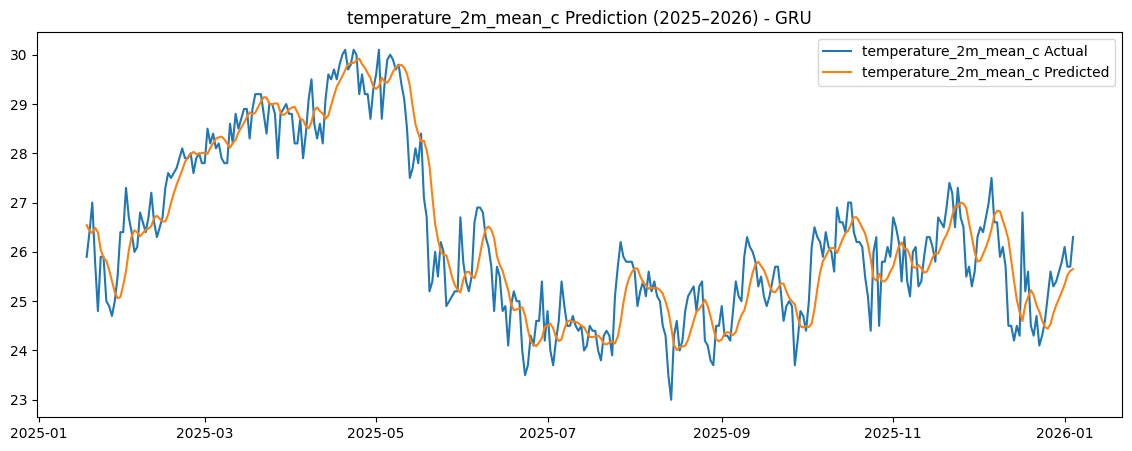

RMSE: 0.6548, MAE: 0.5089




Epoch 0 | Train: 1.0158 | Val: 1.4245
Epoch 5 | Train: 0.8687 | Val: 1.1211
Epoch 10 | Train: 0.4915 | Val: 0.3871
Epoch 15 | Train: 0.3067 | Val: 0.3318
Epoch 20 | Train: 0.3043 | Val: 0.3586
Epoch 25 | Train: 0.2585 | Val: 0.2750
Epoch 29 | Train: 0.2680 | Val: 0.2734


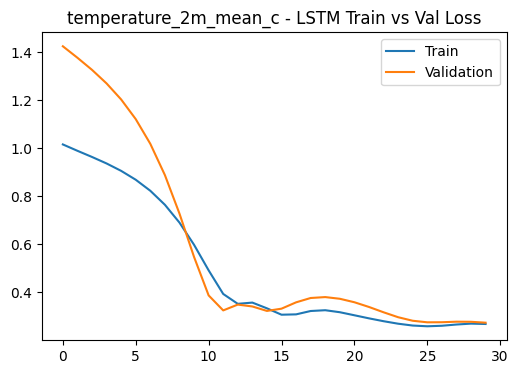

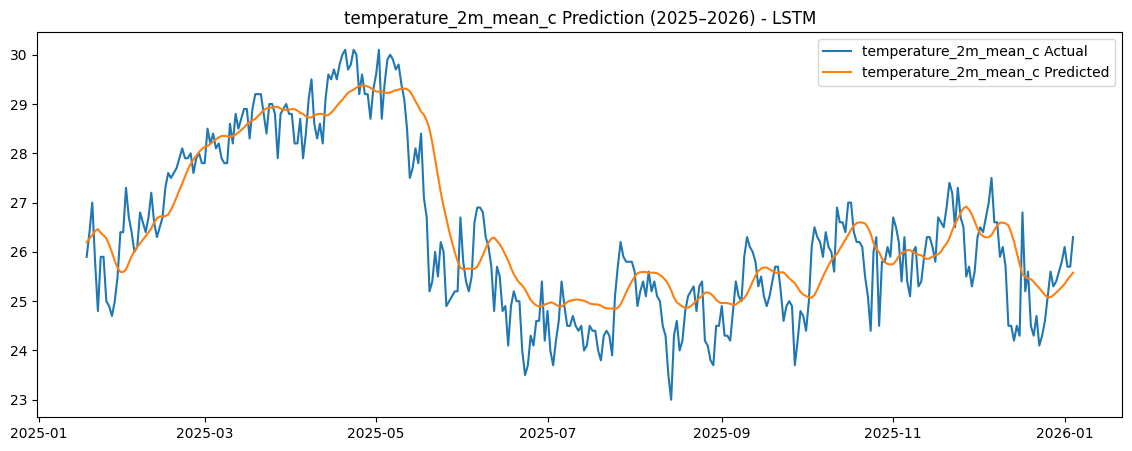

RMSE: 0.7953, MAE: 0.6236






In [14]:
for model in ["RNN", "GRU", "LSTM"]:
    train_sequence_model(
        df, 
        input_features=["temperature_2m_mean_c"], 
        target_features=["temperature_2m_mean_c"],
        model_type=model,
        window=14,
        hidden=128,
        num_layers = 2,
        epochs=30,
        bidirectional = False,
        dropout = 0.0
    )
    print("\n\n\n")

Epoch 0 | Train: 0.9998 | Val: 0.8189
Epoch 5 | Train: 0.5059 | Val: 0.7029
Epoch 10 | Train: 0.4497 | Val: 0.5638
Epoch 15 | Train: 0.4357 | Val: 0.5661
Epoch 20 | Train: 0.4291 | Val: 0.5682
Epoch 25 | Train: 0.4239 | Val: 0.5633
Epoch 29 | Train: 0.4251 | Val: 0.5648


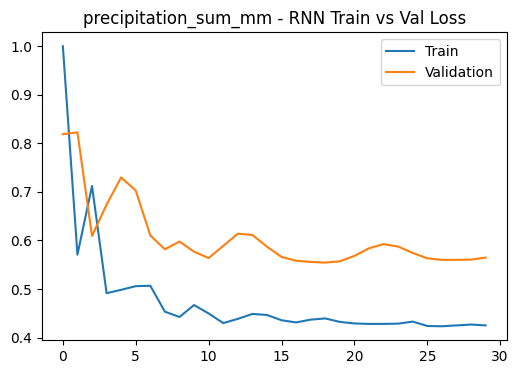

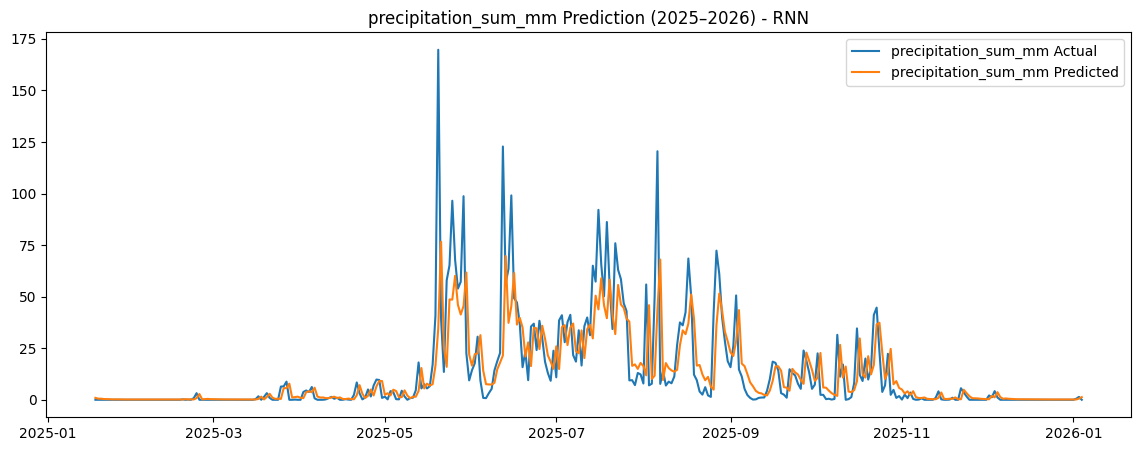

RMSE: 15.6991, MAE: 7.4002




Epoch 0 | Train: 1.0179 | Val: 1.2305
Epoch 5 | Train: 0.5323 | Val: 0.6631
Epoch 10 | Train: 0.4610 | Val: 0.5762
Epoch 15 | Train: 0.4329 | Val: 0.5928
Epoch 20 | Train: 0.4262 | Val: 0.5757
Epoch 25 | Train: 0.4206 | Val: 0.5883
Epoch 29 | Train: 0.4265 | Val: 0.6014


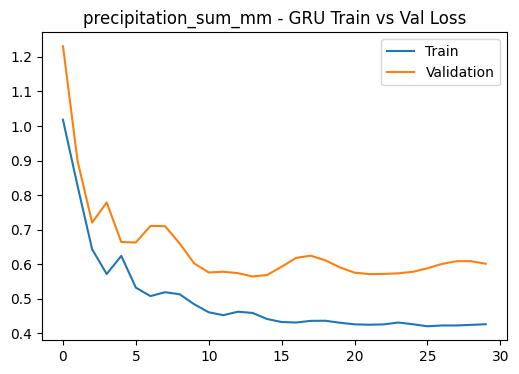

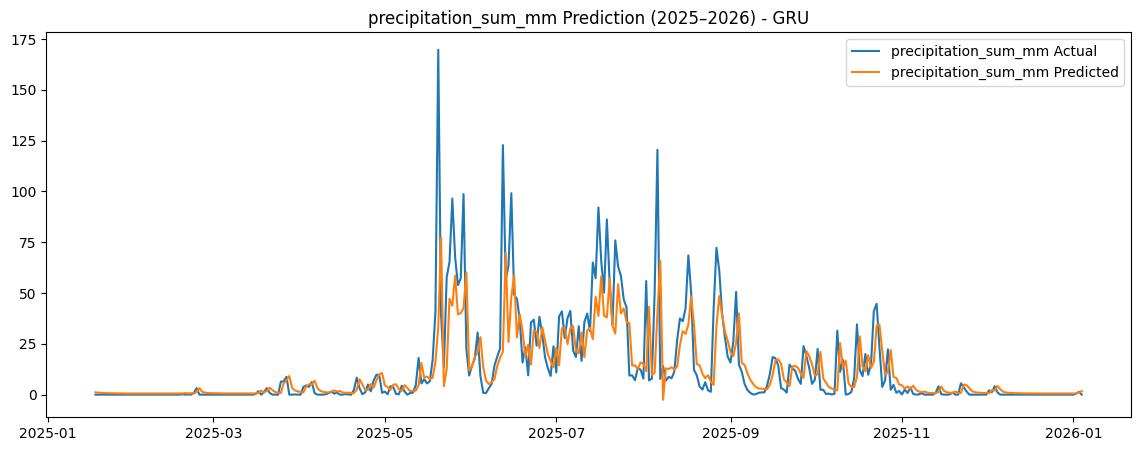

RMSE: 15.9615, MAE: 7.5920






In [16]:
for model in ["RNN", "GRU"]:
    train_sequence_model(
        df, 
        input_features=["precipitation_sum_mm"], 
        target_features=["precipitation_sum_mm"],
        model_type=model,
        window=14,
        hidden=256,
        num_layers = 3,
        epochs=30,
        bidirectional = True,
        dropout = 0.3
    )
    print("\n\n\n")

Epoch 0 | Train: 0.9464 | Val: 1.0534
Epoch 5 | Train: 0.2429 | Val: 0.2408
Epoch 10 | Train: 0.1682 | Val: 0.1820
Epoch 15 | Train: 0.1569 | Val: 0.1779
Epoch 20 | Train: 0.1372 | Val: 0.1566
Epoch 24 | Train: 0.1300 | Val: 0.1490


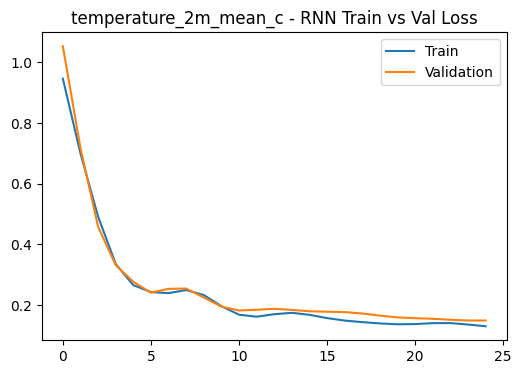

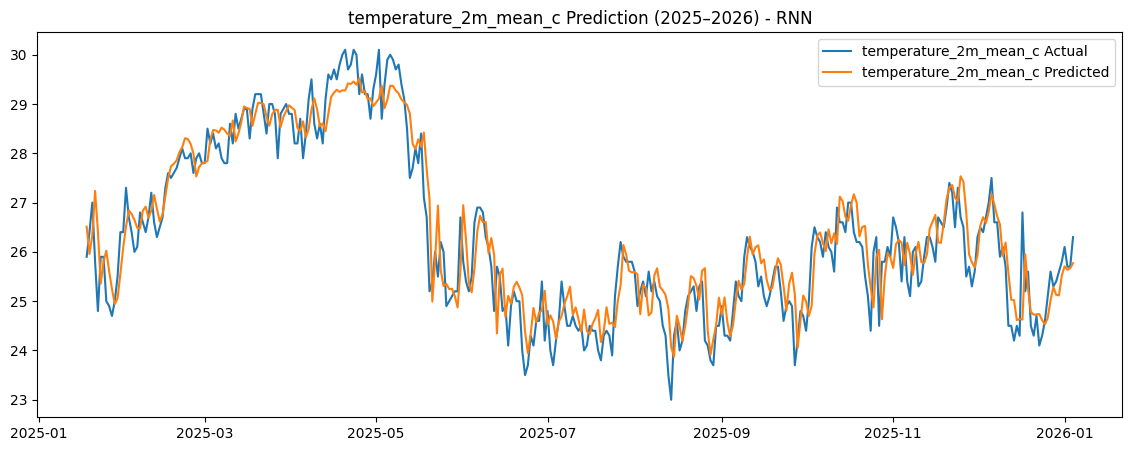

RMSE: 0.5690, MAE: 0.4466




Epoch 0 | Train: 0.9423 | Val: 1.1195
Epoch 5 | Train: 0.2888 | Val: 0.2462
Epoch 10 | Train: 0.2334 | Val: 0.2047
Epoch 15 | Train: 0.2125 | Val: 0.2285
Epoch 20 | Train: 0.1706 | Val: 0.1612
Epoch 24 | Train: 0.1780 | Val: 0.1628


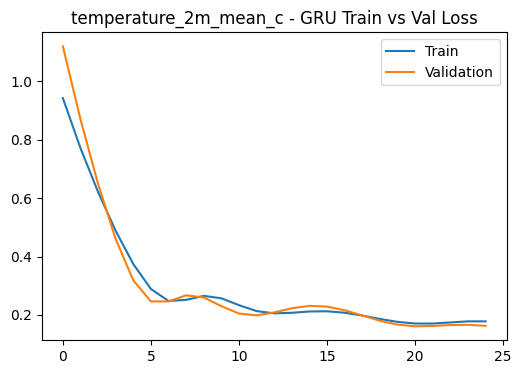

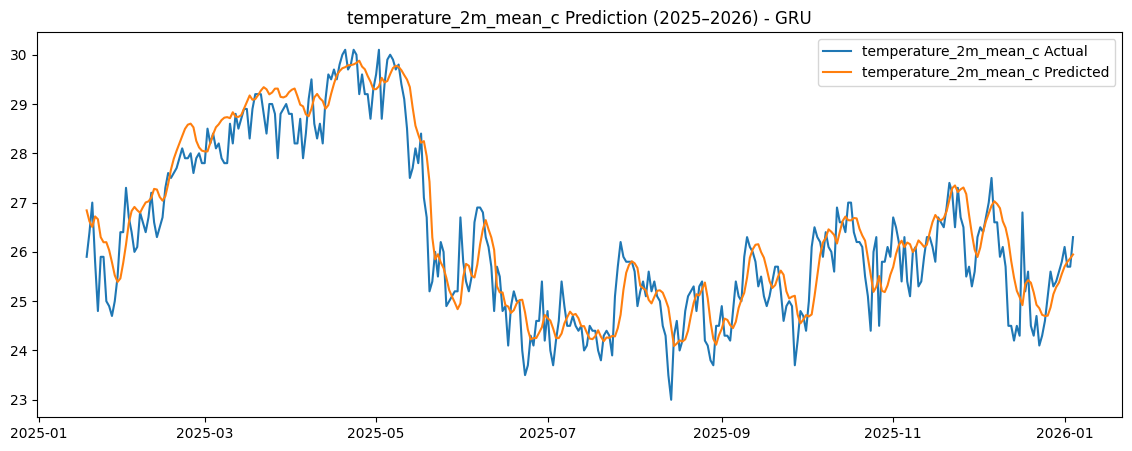

RMSE: 0.6352, MAE: 0.4931




Epoch 0 | Train: 1.0116 | Val: 1.3252
Epoch 5 | Train: 0.6997 | Val: 0.8278
Epoch 10 | Train: 0.3024 | Val: 0.3384
Epoch 15 | Train: 0.2525 | Val: 0.2532
Epoch 20 | Train: 0.2729 | Val: 0.3056
Epoch 24 | Train: 0.2344 | Val: 0.2313


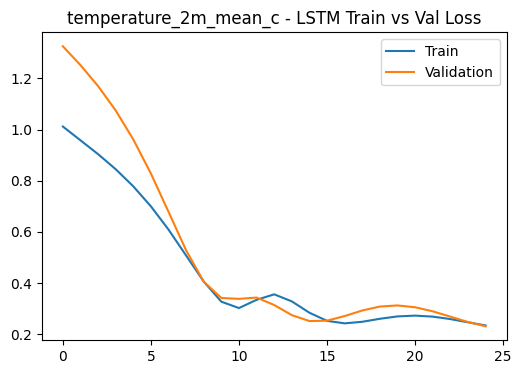

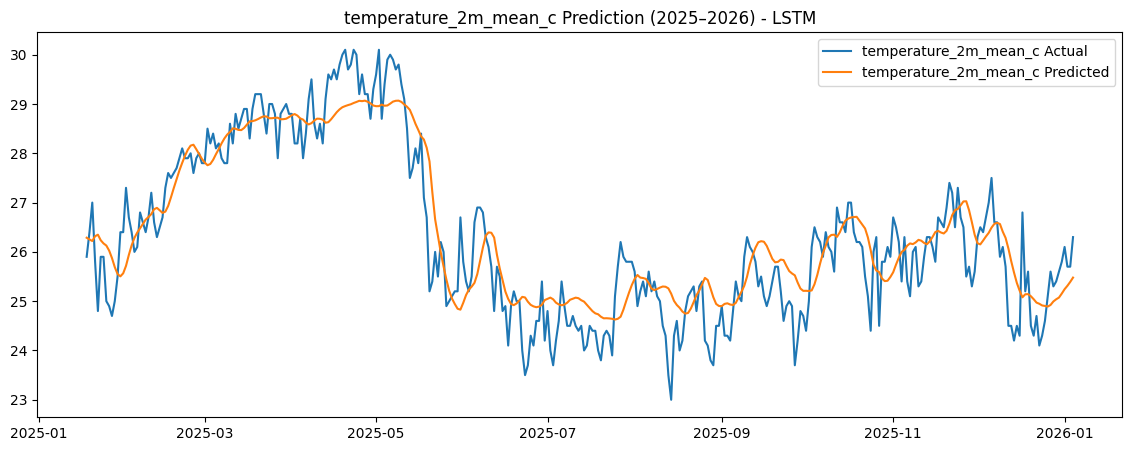

RMSE: 0.7096, MAE: 0.5642






In [17]:
for model in ["RNN", "GRU", "LSTM"]:
    train_sequence_model(
        df, 
        input_features=['temperature_2m_mean_c', 'precipitation_sum_mm',
       'shortwave_radiation_sum_mj_m2', 'apparent_temperature_mean_c',
       'wind_speed_10m_max_km_h', 'et0_fao_evapotranspiration_mm',
       'sunshine_duration_s', 'wind_direction_10m_dominant_',
       'pressure_msl_mean_hpa', 'cloud_cover_mean_%', 'dew_point_2m_mean_c',
       'soil_moisture_0_to_7cm_mean_m3_m3'], 
        target_features=["temperature_2m_mean_c"],
        model_type=model,
        window=14,
        hidden=128,
        num_layers = 2,
        epochs=25,
        bidirectional = False,
        dropout=0.0
    )
    print("\n\n\n")

Epoch 0 | Train: 1.0429 | Val: 1.2425
Epoch 5 | Train: 0.5623 | Val: 0.7427
Epoch 10 | Train: 0.4822 | Val: 0.7230
Epoch 15 | Train: 0.4376 | Val: 0.6222
Epoch 20 | Train: 0.4149 | Val: 0.6441
Epoch 25 | Train: 0.4087 | Val: 0.6242
Epoch 30 | Train: 0.4038 | Val: 0.6128
Epoch 35 | Train: 0.3985 | Val: 0.6028
Epoch 40 | Train: 0.3937 | Val: 0.5816
Epoch 45 | Train: 0.3905 | Val: 0.5789
Epoch 50 | Train: 0.3880 | Val: 0.5666
Epoch 55 | Train: 0.3856 | Val: 0.5658
Epoch 60 | Train: 0.3833 | Val: 0.5626
Epoch 65 | Train: 0.3810 | Val: 0.5660
Epoch 70 | Train: 0.3786 | Val: 0.5650
Epoch 75 | Train: 0.3761 | Val: 0.5682
Epoch 80 | Train: 0.3735 | Val: 0.5707
Epoch 85 | Train: 0.3707 | Val: 0.5752
Epoch 90 | Train: 0.3676 | Val: 0.5816
Epoch 95 | Train: 0.3644 | Val: 0.5824
Epoch 99 | Train: 0.3616 | Val: 0.5845


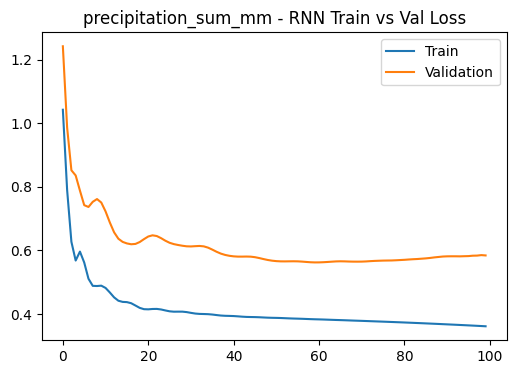

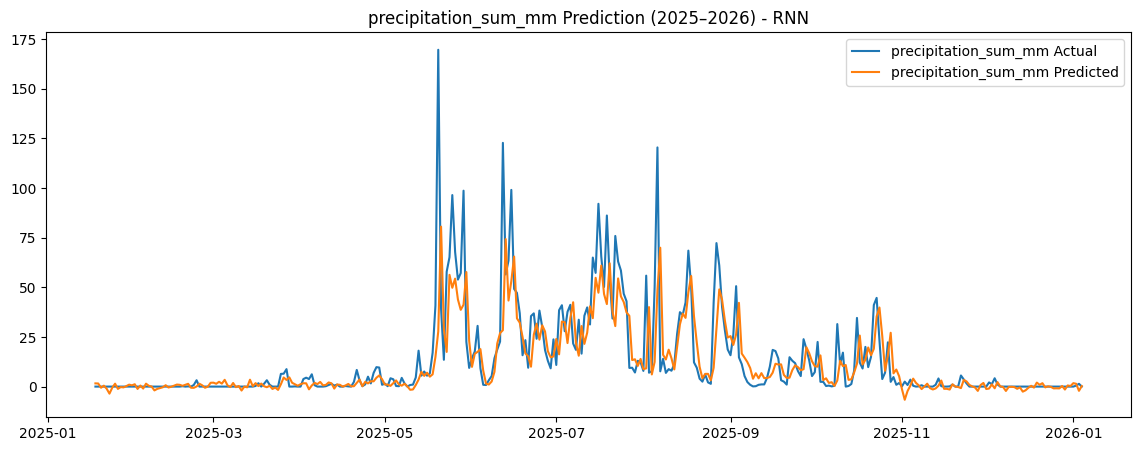

RMSE: 15.3679, MAE: 7.1782




Epoch 0 | Train: 0.9990 | Val: 1.3410
Epoch 5 | Train: 0.5995 | Val: 0.8537
Epoch 10 | Train: 0.5392 | Val: 0.7939
Epoch 15 | Train: 0.5180 | Val: 0.7789
Epoch 20 | Train: 0.4787 | Val: 0.6933
Epoch 25 | Train: 0.4485 | Val: 0.6642
Epoch 30 | Train: 0.4277 | Val: 0.6544
Epoch 35 | Train: 0.4074 | Val: 0.6169
Epoch 40 | Train: 0.3983 | Val: 0.6153
Epoch 45 | Train: 0.3942 | Val: 0.6154
Epoch 50 | Train: 0.3900 | Val: 0.6027
Epoch 55 | Train: 0.3858 | Val: 0.5938
Epoch 60 | Train: 0.3831 | Val: 0.5853
Epoch 65 | Train: 0.3807 | Val: 0.5818
Epoch 70 | Train: 0.3785 | Val: 0.5811
Epoch 75 | Train: 0.3764 | Val: 0.5814
Epoch 80 | Train: 0.3745 | Val: 0.5813
Epoch 85 | Train: 0.3727 | Val: 0.5819
Epoch 90 | Train: 0.3709 | Val: 0.5839
Epoch 95 | Train: 0.3690 | Val: 0.5860
Epoch 99 | Train: 0.3674 | Val: 0.5874


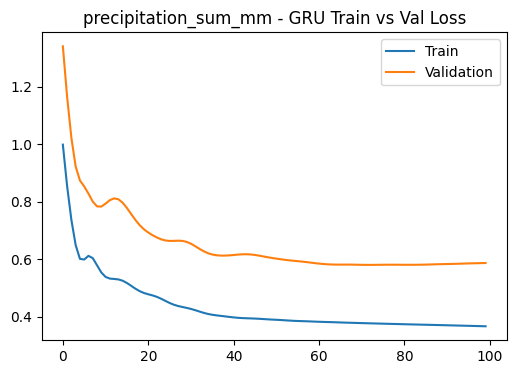

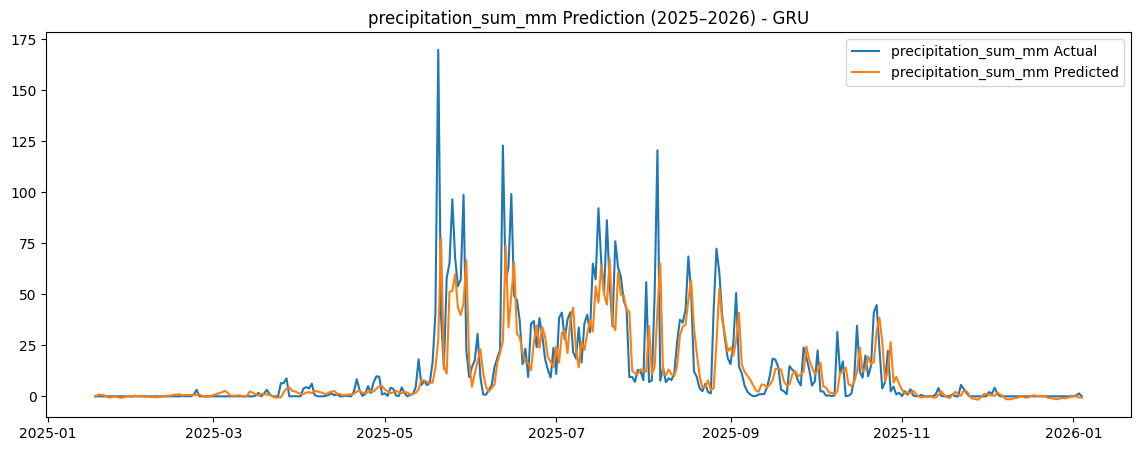

RMSE: 15.4807, MAE: 7.0129




Epoch 0 | Train: 1.0051 | Val: 1.5083
Epoch 5 | Train: 0.7477 | Val: 1.0658
Epoch 10 | Train: 0.6610 | Val: 0.8746
Epoch 15 | Train: 0.5890 | Val: 0.9067
Epoch 20 | Train: 0.5580 | Val: 0.8108
Epoch 25 | Train: 0.5314 | Val: 0.7821
Epoch 30 | Train: 0.5070 | Val: 0.7917
Epoch 35 | Train: 0.4792 | Val: 0.7400
Epoch 40 | Train: 0.4532 | Val: 0.7291
Epoch 45 | Train: 0.4272 | Val: 0.6760
Epoch 50 | Train: 0.4056 | Val: 0.6543
Epoch 55 | Train: 0.3940 | Val: 0.6407
Epoch 60 | Train: 0.3894 | Val: 0.6416
Epoch 65 | Train: 0.3833 | Val: 0.6321
Epoch 70 | Train: 0.3789 | Val: 0.6240
Epoch 75 | Train: 0.3746 | Val: 0.6145
Epoch 80 | Train: 0.3703 | Val: 0.6137
Epoch 85 | Train: 0.3659 | Val: 0.6155
Epoch 90 | Train: 0.3619 | Val: 0.6267
Epoch 95 | Train: 0.3569 | Val: 0.6319
Epoch 99 | Train: 0.3537 | Val: 0.6268


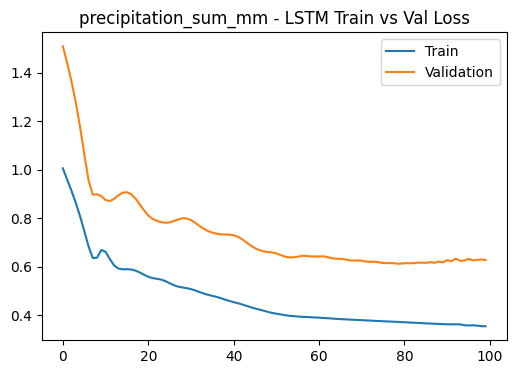

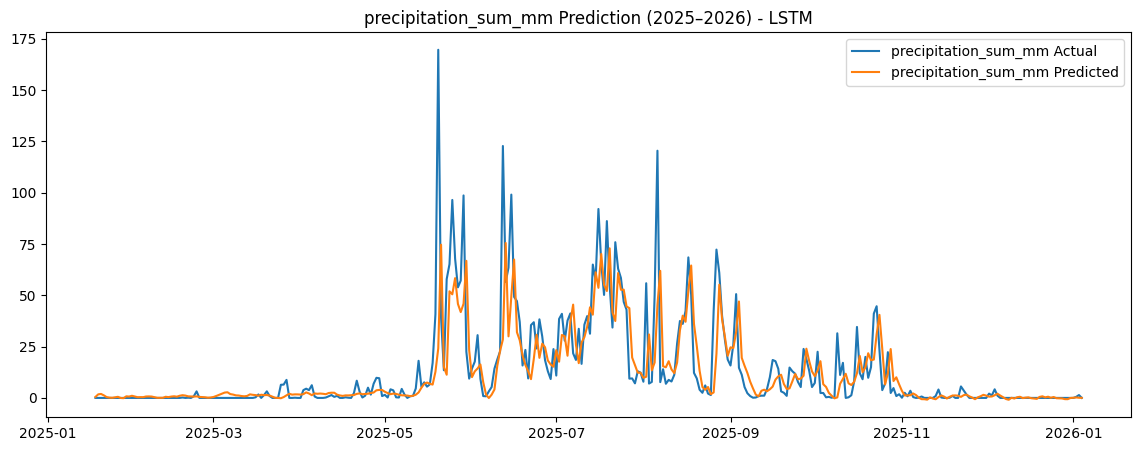

RMSE: 15.4451, MAE: 7.0710






In [ ]:
for model in ["RNN", "GRU", "LSTM"]:
    train_sequence_model(
        df, 
        input_features=['temperature_2m_mean_c', 'precipitation_sum_mm',
       'shortwave_radiation_sum_mj_m2', 'apparent_temperature_mean_c',
       'wind_speed_10m_max_km_h', 'et0_fao_evapotranspiration_mm',
       'sunshine_duration_s', 'wind_direction_10m_dominant_',
       'pressure_msl_mean_hpa', 'cloud_cover_mean_%', 'dew_point_2m_mean_c',
       'soil_moisture_0_to_7cm_mean_m3_m3'], 
        target_features=['precipitation_sum_mm'],
        model_type=model,
        window=14,
        hidden=256,
        num_layers = 3,
        epochs=100,
        bidirectional = True,
        dropout = 0.3
    )
    print("\n\n\n")

Epoch 0 | Train: 0.9137 | Val: 0.9445
Epoch 5 | Train: 0.4421 | Val: 0.6430
Epoch 10 | Train: 0.4344 | Val: 0.5953
Epoch 15 | Train: 0.4172 | Val: 0.5628
Epoch 20 | Train: 0.4068 | Val: 0.5501
Epoch 25 | Train: 0.4011 | Val: 0.5580
Epoch 30 | Train: 0.3953 | Val: 0.5542
Epoch 35 | Train: 0.3919 | Val: 0.5497
Epoch 40 | Train: 0.3898 | Val: 0.5486
Epoch 45 | Train: 0.3860 | Val: 0.5416
Epoch 50 | Train: 0.3793 | Val: 0.5366
Epoch 55 | Train: 0.3757 | Val: 0.5451
Epoch 60 | Train: 0.3735 | Val: 0.5498
Epoch 65 | Train: 0.3690 | Val: 0.5562
Epoch 70 | Train: 0.3648 | Val: 0.5573
Epoch 75 | Train: 0.3644 | Val: 0.5823
Epoch 80 | Train: 0.3608 | Val: 0.5796
Epoch 85 | Train: 0.3555 | Val: 0.5930
Epoch 90 | Train: 0.3501 | Val: 0.5974
Epoch 95 | Train: 0.3423 | Val: 0.6076
Epoch 99 | Train: 0.3365 | Val: 0.6086


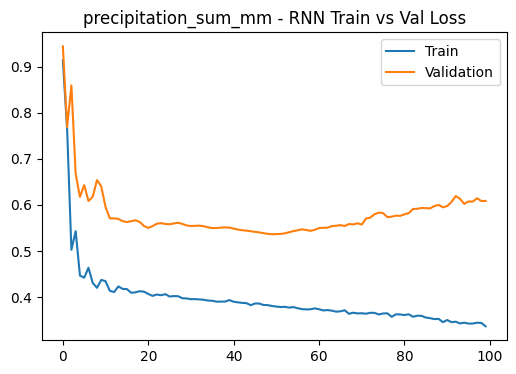

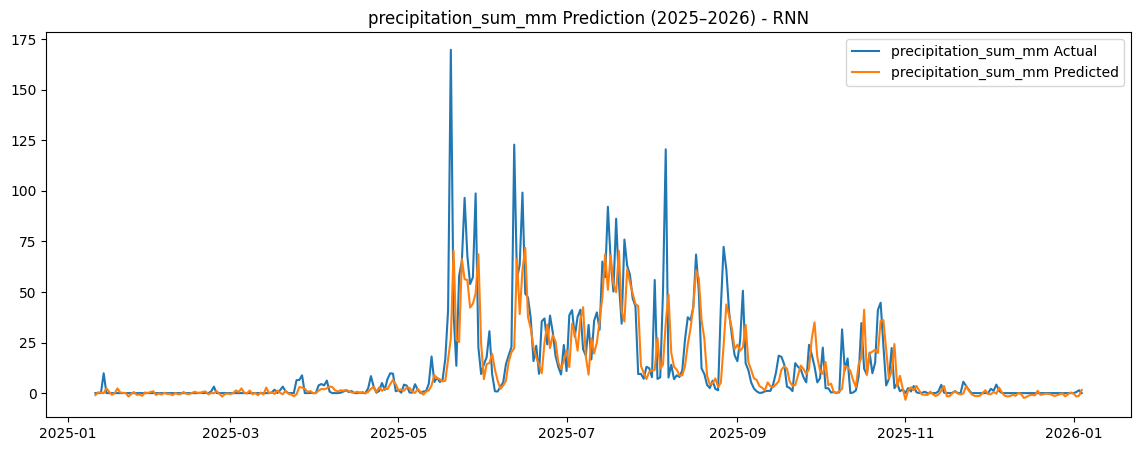

RMSE: 15.0083, MAE: 6.7571




Epoch 0 | Train: 0.9926 | Val: 0.9862
Epoch 5 | Train: 0.5564 | Val: 0.7790
Epoch 10 | Train: 0.4437 | Val: 0.6426
Epoch 15 | Train: 0.4183 | Val: 0.5895
Epoch 20 | Train: 0.4085 | Val: 0.6016
Epoch 25 | Train: 0.3976 | Val: 0.5781
Epoch 30 | Train: 0.3909 | Val: 0.5788
Epoch 35 | Train: 0.3872 | Val: 0.5799
Epoch 40 | Train: 0.3832 | Val: 0.5788
Epoch 45 | Train: 0.3813 | Val: 0.5813
Epoch 50 | Train: 0.3757 | Val: 0.5743
Epoch 55 | Train: 0.3714 | Val: 0.5789
Epoch 60 | Train: 0.3693 | Val: 0.5860
Epoch 65 | Train: 0.3697 | Val: 0.5909
Epoch 70 | Train: 0.3644 | Val: 0.5884
Epoch 75 | Train: 0.3622 | Val: 0.5998
Epoch 80 | Train: 0.3602 | Val: 0.6089
Epoch 85 | Train: 0.3545 | Val: 0.6146
Epoch 90 | Train: 0.3471 | Val: 0.6177
Epoch 95 | Train: 0.3475 | Val: 0.6220
Epoch 99 | Train: 0.3412 | Val: 0.6392


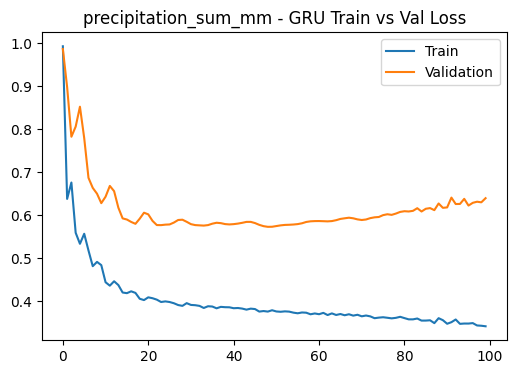

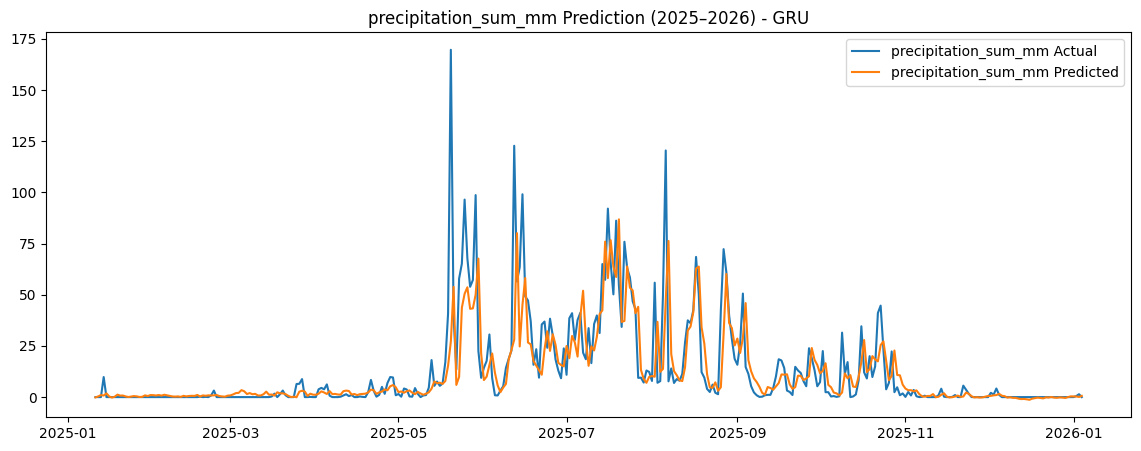

RMSE: 15.2987, MAE: 6.9563




Epoch 0 | Train: 1.0000 | Val: 1.4301
Epoch 5 | Train: 0.6906 | Val: 0.8030
Epoch 10 | Train: 0.5549 | Val: 0.7702
Epoch 15 | Train: 0.4754 | Val: 0.6742
Epoch 20 | Train: 0.4419 | Val: 0.6351
Epoch 25 | Train: 0.4132 | Val: 0.6189
Epoch 30 | Train: 0.3990 | Val: 0.5916
Epoch 35 | Train: 0.3925 | Val: 0.6073
Epoch 40 | Train: 0.3870 | Val: 0.5854
Epoch 45 | Train: 0.3827 | Val: 0.5866
Epoch 50 | Train: 0.3751 | Val: 0.5965
Epoch 55 | Train: 0.3750 | Val: 0.5928
Epoch 60 | Train: 0.3680 | Val: 0.5889
Epoch 65 | Train: 0.3649 | Val: 0.5852
Epoch 70 | Train: 0.3600 | Val: 0.5914
Epoch 75 | Train: 0.3535 | Val: 0.5981
Epoch 80 | Train: 0.3531 | Val: 0.6092
Epoch 85 | Train: 0.3449 | Val: 0.6110
Epoch 90 | Train: 0.3445 | Val: 0.6188
Epoch 95 | Train: 0.3412 | Val: 0.6384
Epoch 99 | Train: 0.3355 | Val: 0.6371


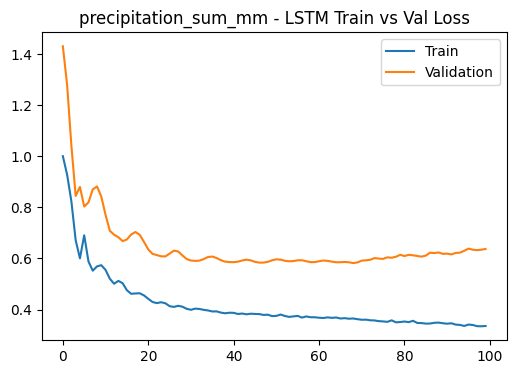

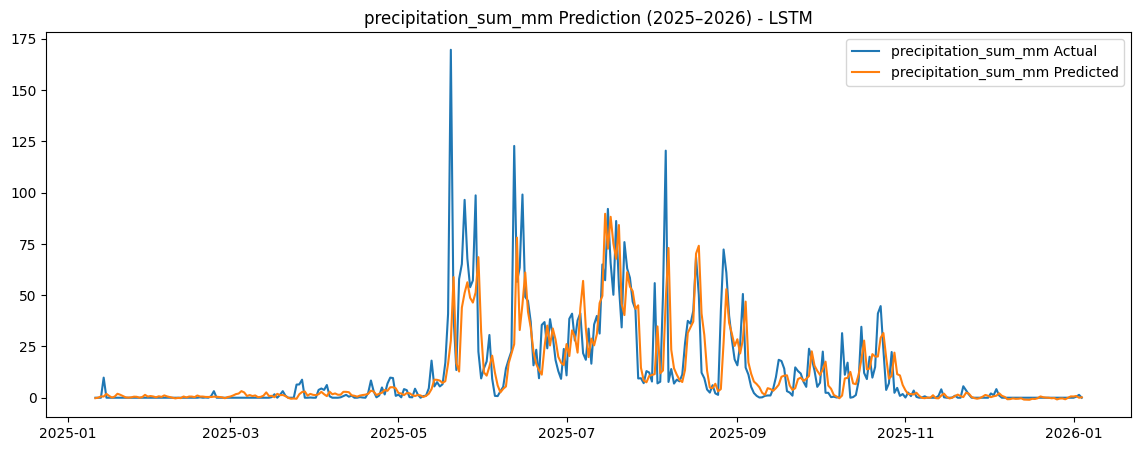

RMSE: 15.2768, MAE: 7.0359






In [19]:
for model in ["RNN", "GRU", "LSTM"]:
    train_sequence_model(
        df, 
        input_features=['temperature_2m_mean_c', 'precipitation_sum_mm',
       'shortwave_radiation_sum_mj_m2', 'apparent_temperature_mean_c',
       'wind_speed_10m_max_km_h', 'et0_fao_evapotranspiration_mm',
       'sunshine_duration_s', 'wind_direction_10m_dominant_',
       'pressure_msl_mean_hpa', 'cloud_cover_mean_%', 'dew_point_2m_mean_c',
       'soil_moisture_0_to_7cm_mean_m3_m3'], 
        target_features=['precipitation_sum_mm'],
        model_type=model,
        window=7,
        hidden=256,
        num_layers = 3,
        epochs=100,
        bidirectional = True,
        dropout = 0.3
    )
    print("\n\n\n")

# Prediction Analysis
| Task | Model | RMSE | MAE |
|------|-------|------|-----|
| Temperature → Temperature (Univariate) | RNN  | 0.5656 | 0.4492 |
| Temperature → Temperature (Univariate) | GRU  | 0.6548 | 0.5089 |
| Temperature → Temperature (Univariate) | LSTM | 0.7953 | 0.6236 |
| Precipitation → Precipitation (Univariate) | RNN  | 15.6991 | 7.4002 |
| Precipitation → Precipitation (Univariate) | GRU  | 15.9615 | 7.5920 |
| All Factors → Temperature (Multivariate) | RNN  | 0.5690 | 0.4466 |
| All Factors → Temperature (Multivariate) | GRU  | 0.6352 | 0.4931 |
| All Factors → Temperature (Multivariate) | LSTM | 0.7096 | 0.5642 |
| All Factors → Precipitation (Multivariate) | RNN  | 15.3679 | 7.1782 |
| All Factors → Precipitation (Multivariate) | GRU  | 15.4807 | 7.0129 |
| All Factors → Precipitation (Multivariate) | LSTM | 15.4451 | 7.0710 |
| All Factors → Precipitation (Alt. Architecture) | RNN  | 15.0083 | 6.7571 |
| All Factors → Precipitation (Alt. Architecture) | GRU  | 15.2987 | 6.9563 |
| All Factors → Precipitation (Alt. Architecture) | LSTM | 15.2768 | 7.0359 |

In the temperature univariate model, error in RNN is less than GRU and LSTM which is counter intuitive. Manipal's weather is highly varying so long term memory may not crucial this may be why RNN performs better. Also, maybe the GRU and LSTM overfit due to their complexity. 
The multivariate counterpart performs even worse, this maybe due to the fact that the other features are redundant and only provide noise.

The precipation predictions did not reach the required <=12.5 RMSE. I made the precipiation models much more complex than the tempreature one. It is bidirectonal, the hidden unit has more dimensions, it has one more layer and even after experimenting with different windows of time I could not reach the desired RMSE value. This can be attributed to the fact that precipiation is much harder to predict than temperature and requires knowledge of alot of other factors. Manipal being near the coast its even harder with sudden winds disrupting trends.